In [2]:
import pandas as pd
import numpy as np
import statistics 
import seaborn as sns
import pickle
import statsmodels.api as sm
from IPython.display import display
from sklearn import metrics, neighbors, preprocessing
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

## TRAIN TEST

In [3]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## DATA ANLYSIS

In [4]:
# list of explanatory variables
features = df.columns.tolist()
features

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [5]:
# # of parents / children aboard the Titanic
parch_unique = df['Parch'].unique()
np.sort(parch_unique)

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
# # of siblings / spouses aboard the Titanic
sibsp_unique = df['SibSp'].unique()
np.sort(sibsp_unique)

array([0, 1, 2, 3, 4, 5, 8])

In [7]:
sex_unique = df['Sex'].unique()
np.sort(sex_unique)

array(['female', 'male'], dtype=object)

In [8]:
df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

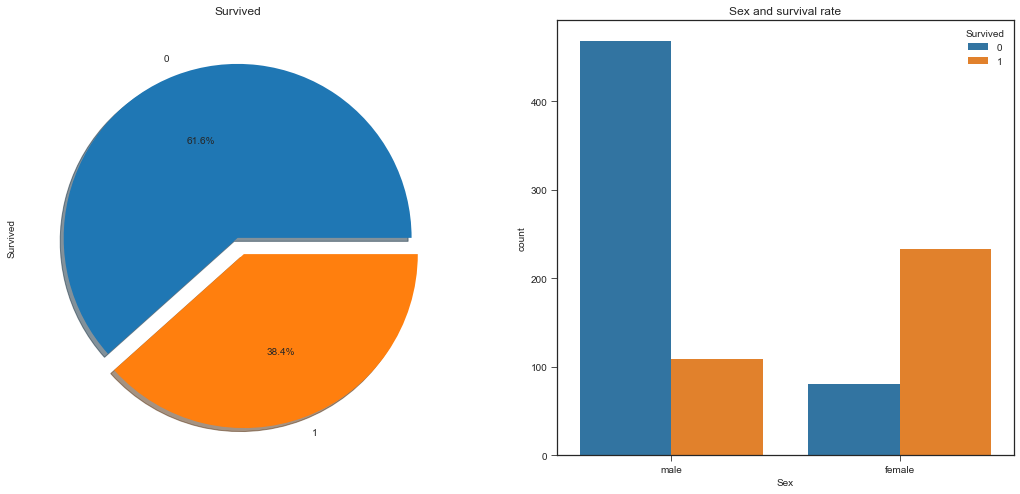

In [9]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('Survived')

sns.countplot(x='Sex', hue='Survived', data=df, ax=ax[1])
ax[1].set_title('Sex and survival rate')

plt.show()

Average age on board: : 30.0


Text(0.5, 0, 'Age')

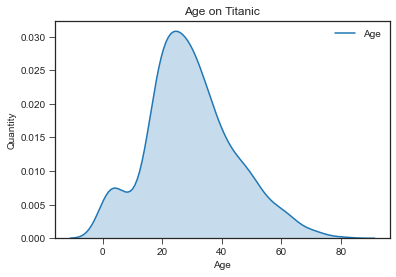

In [10]:
print("Average age on board: :", np.round(df['Age'].mean(),0))
sns.kdeplot(data=df['Age'], shade=True)
plt.title("Age on Titanic")
plt.ylabel('Quantity')
plt.xlabel('Age')

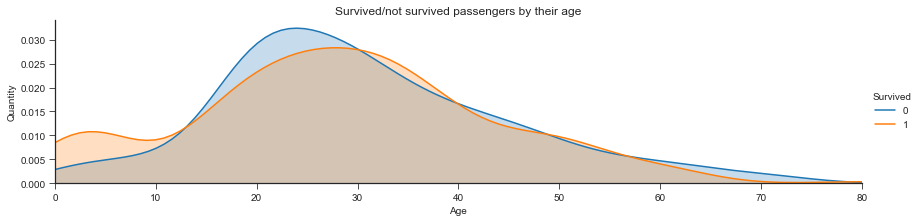

In [11]:
w = sns.FacetGrid(df, hue="Survived",aspect=4)
w.map(sns.kdeplot,'Age',shade= True)
w.set(xlim=(0, df['Age'].max()))
plt.title("Survived/not survived passengers by their age")
plt.ylabel('Quantity')
w.add_legend()

Text(0.5, 1.0, 'Age and survived')

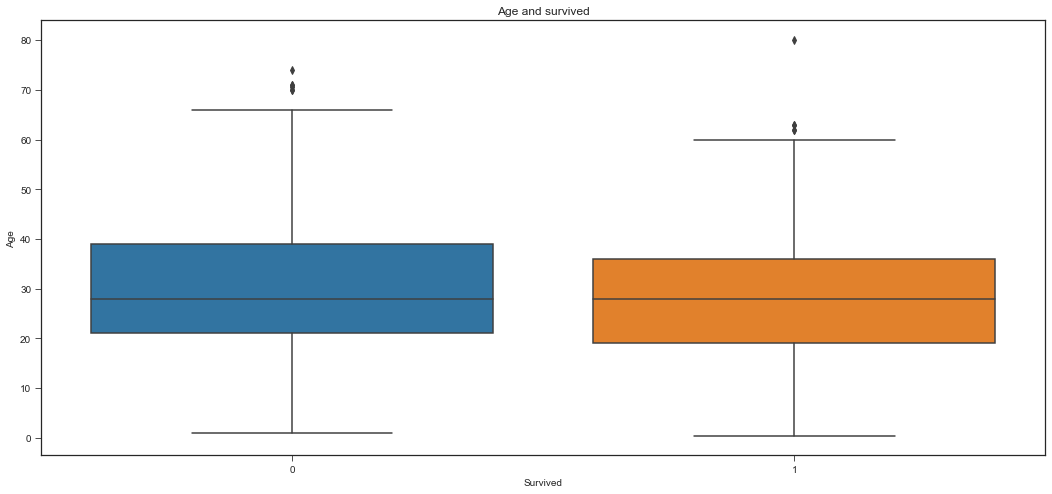

In [12]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title("Age and survived")

The average age of the survivors and non-survivors is comparable.

In [13]:
df.groupby(['Survived'])['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

The median for survival is lower than for the dead. More elderly people were in the group of the deceased. On the other hand, youth and being a young child did not guarantee survival.

Text(0.5, 1.0, 'Fare and survived')

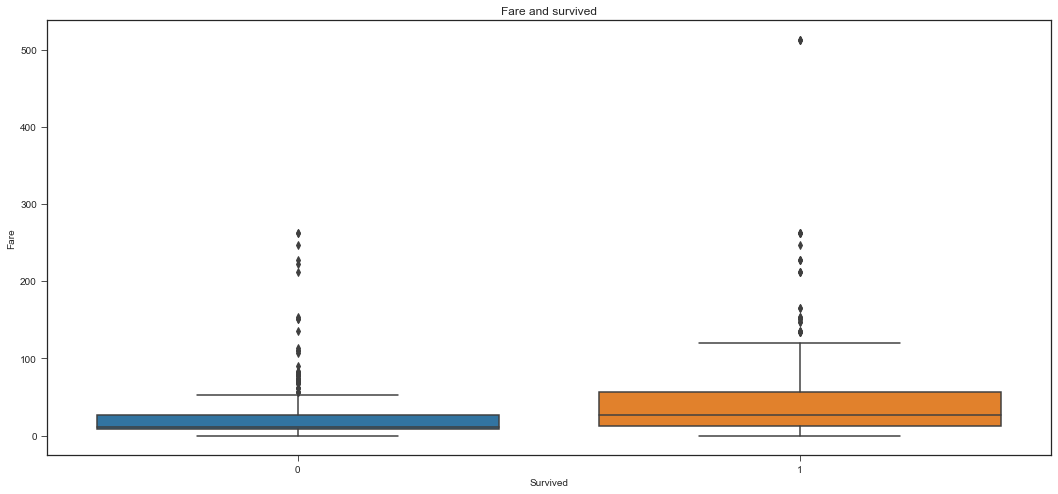

In [14]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df)

plt.title("Fare and survived")

Remove outlier from df['Fare']

In [15]:
print("Counting of unique values in df.Embarked")
df.Embarked.value_counts()

Counting of unique values in df.Embarked


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Fare and survived')

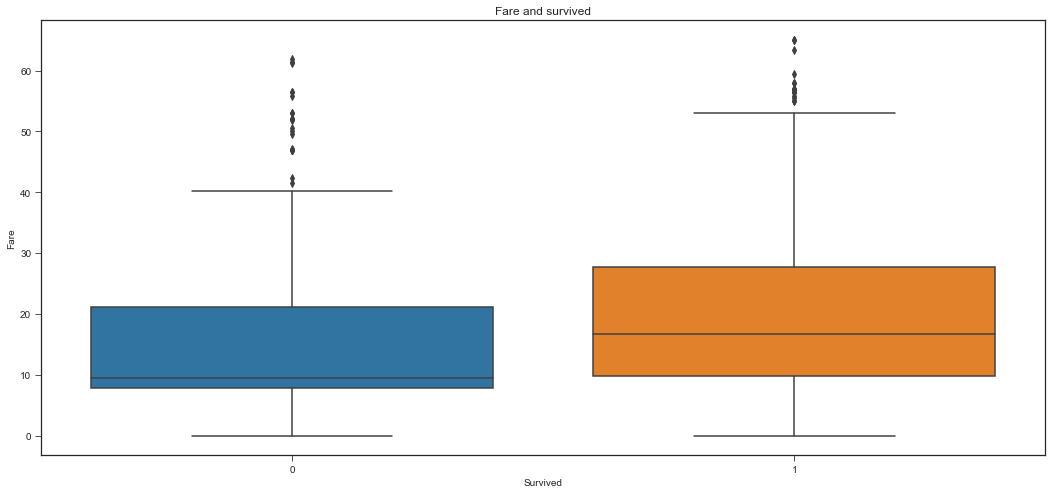

In [16]:
df3 = pd.read_csv("train.csv")

Q1 = df3['Fare'].quantile(0.25)
Q3 = df3['Fare'].quantile(0.75)
IQR = Q3-Q1 
fence_low  = Q1-1.5*IQR
fence_high = Q3+1.5*IQR
mask = (df3['Fare'] > fence_high) | (df3['Fare'] < fence_low)
df3.loc[mask, 'Fare'] = np.nan
    
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df3)
plt.title("Fare and survived")

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


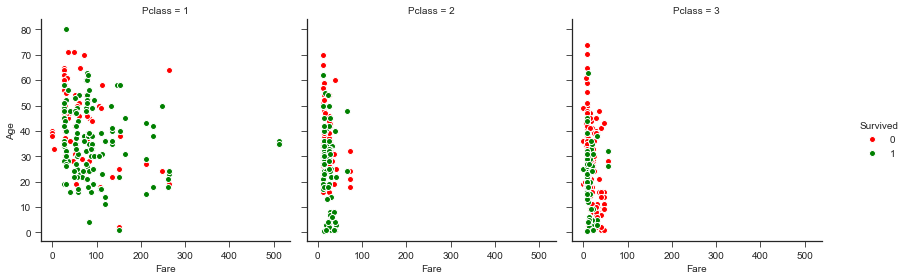

In [17]:
g = sns.FacetGrid(df, hue="Survived", col="Pclass", margin_titles=True,palette={1:"green", 0:"red"}, size=4, aspect=1)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

Text(0.5, 0.98, 'Survival by Gender , Age and Fare')

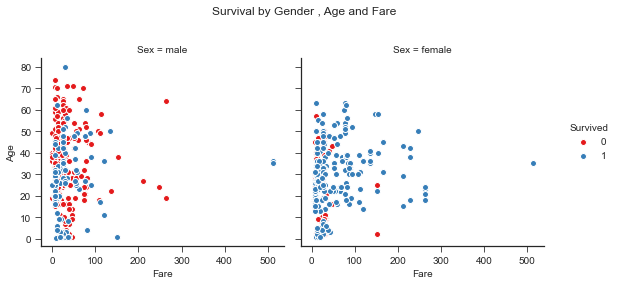

In [18]:
g = sns.FacetGrid(df, hue="Survived", col="Sex", margin_titles=True, palette="Set1", size=4, aspect=1)

g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)

g.fig.suptitle('Survival by Gender , Age and Fare')

## TEST SET

In [19]:
df_test = pd.read_csv("test.csv")
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## CLEANING

In [21]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [22]:
# get the number of missing data points per column
missing_values_count_test = df_test.isnull().sum()
print(missing_values_count_test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [23]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(df[['Age']], df[['Fare']])

def cleaning(df):
    
    #Age
    df['Age'] = imputer.transform(df[['Age']])

    #Cabin
    df['Cabin'] = [x[0] if isinstance(x, str) else np.nan for x in df['Cabin']]
    df['Cabin'] = df['Cabin'].fillna('no_data')
         
    #Embarked 
    if df['Embarked'].isnull().sum() != 0:
        #filling the most common value
        df['Embarked'] = df['Embarked'].fillna('S')
    
    #Fare
    if df['Fare'].isnull().sum() != 0:
        df['Fare'] = imputer.transform(df[['Fare']])
    

In [24]:
cleaning(df)
cleaning(df_test)

In [25]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [26]:
missing_values_count_test = df_test.isnull().sum()
print(missing_values_count_test)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## ONE HOT ENCODING

In [27]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns


In [28]:
target = 'Survived'
numFeatures = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
catFeatures = ['Sex', 'Cabin', 'Embarked']

encoder = OneHotEncoder()
encoder_cols_train = encoder.fit_transform(df[catFeatures])
encoder_cols_test = encoder.transform(df_test[catFeatures])

In [29]:
num_df_train = df[numFeatures]
num_df_test = df_test[numFeatures]

target_df_train = df[target]

temp = pd.concat([num_df_train, encoder_cols_train], axis=1)

# Add one-hot encoded columns to numerical features
df = pd.concat([temp, target_df_train], axis=1)
df_test = pd.concat([num_df_test, encoder_cols_test], axis=1)

In [30]:
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [31]:
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [32]:
features = df.columns.tolist()
features.remove(target)

y_train = df[target]
X_train = df[features]
X_test = df_test

## ROC CURVE

In [48]:
def plotROCs(results):
    ''' Function for drawing a series of ROC curve results for 
    individual experiments
     results - results list as 3 element tuples 
     (true, pred, label)
    '''
    
    # Determining the size of the drawing
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        
        # Calculation of the points needed to draw the ROC curve
        # the roc_curve function concludes three data series, fpr, 
        #tpr, and cutoff levels
        fpr, tpr, thresholds = roc_curve(true, pred)
        
        # We calculate the area under the curve
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        

        # curve thickness
        lw = 2

        # We draw the ROC curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
        
    # We draw a 45 degree curve as a reference point
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    # We add light margins to the range so that the curve 
    #does not coincide with the axes
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    #plt.savefig('ROC.png')
    plt.show()

## CROSS VALIDATION

##### wrapper for cross validation

In [71]:
def CVmodel(nFolds = 5, randomState=2020, debug=False, features=features, 
            model = SVC()):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save memory, the folder information is only line numbers
    testResults = []
    
    # the results on the training set
    trainResults = []
    
    # predictions for individual folds
    predictions = []
    
    # the index in the original file
    indices = []
    
    for train, test in kf.split(df.index.values):
        
        if debug:
            print(model)
       
        model.fit(df.iloc[train][features], df.iloc[train][target])
        
        predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]
        
        # information about predictions for this fold
        predictions.append(preds.tolist().copy())
        
        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # The fit is counted using the ROC-AUC metric
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Saving the results to the list 
        trainResults.append(trainScore)
        testResults.append(testScore)

        
        # Information about each folder together with training results
        #can be optionally displayed in the process
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
    
        
    return trainResults, testResults, predictions, indices

In [74]:
def draw(models):
    res2plot = []
    true = (df[target]==1)
    for result in models:
        pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
        res2plot.append((true, pred, result["name"]))

    # We call the drawing function
    plotROCs(res2plot)

## GridSearchCV

In [34]:
def GridSearchCV:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

    # param_grid = {
    #     'n_estimators': [50, 100, 200, 500],
    #     'max_depth': [ 14 ,  16 ,  18 ,  20 ,  22 ],
    #     'max_features': [2,  8 ,  10 ,  12 ,  16 ,  18],
    #     'min_samples_split': [2, 4, 8, 10]
    # }

    param_grid = { 'base_estimator__max_depth': [2, 4, 6, 10, 16, 20],
                  'base_estimator__n_estimators': [50, 100, 200, 500],
                  'base_estimator__max_features': [2,  8 ,  10 ,  12 ,  16 ,  18],
                  'base_estimator__min_samples_split': [2, 4, 8, 10]}

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier())

        clf = GridSearchCV(calibrated_forest, param_grid, scoring='%s_macro' % score)

        clf.fit(Xtrain, ytrain)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
    #     print("Grid scores on development set:")
    #     print()
    #     means = clf.cv_results_['mean_test_score']
    #     stds = clf.cv_results_['std_test_score']
    #     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #         print("%0.3f (+/-%0.03f) for %r"
    #               % (mean, std * 2, params))
    #     print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = ytest, clf.predict(Xtest)
        print(classification_report(y_true, y_pred))
        print()

SyntaxError: invalid syntax (<ipython-input-34-b101ee6bde6f>, line 1)

## RANDOM FOREST

In [72]:
rfc = RandomForestClassifier(random_state=2020, n_jobs=-1)
trainResults, testResults, predictions, indices = CVmodel(debug=True, model=rfc)
print(np.mean(testResults))
print(testResults)

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9985293128949846 Valid AUC: 0.845945945945946
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9980559614383366 Valid AUC: 0.906925566343042
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9982087029995775 Valid AUC: 0.8433704129906662
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9974023022096667 Valid AUC: 0.8737980769230769
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9981262229297251 Valid AUC: 0.8461174242424243
0.863231485289031
[0.845945945945946, 0.906925566343042, 0.8433704129906662, 0.8737980769230769, 0.8461174242424243]


You can see that the trees in the Random Forest were overfitted.

In [ ]:
models = {}

for k in [10, 25, 50, 100, 200, 500, 1000]:
    
    rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=k)
    trainResults, testResults, predictions, indices = CVmodel(model=rfc)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) 
          - np.mean(testResults))
    name = 'rfc '+str(k)
    models[name] = {
        "predictions": predictions.copy(),
        "indices": indices.copy(),
    }
    
draw(models)

10 0.99644757824326 0.8420113816387781 0.15443619660448193
25 0.997787110789546 0.8544187162294881 0.1433683945600579
50 0.9980036232902438 0.8601691655896676 0.13783445770057623
100 0.998064500494458 0.863231485289031 0.134833015205427
200 0.9981892582222587 0.8645122145243812 0.13367704369787747


In [291]:
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.8598079236259025 0.8465027494600337 0.01330517416586885
4 0.8882702398827724 0.8598773657963058 0.028392874086466624
6 0.9252383236901671 0.8660958281121627 0.05914249557800444
8 0.9589460800411581 0.8639930642167929 0.09495301582436522
10 0.9791819368534208 0.8648906352422037 0.11429130161121714
12 0.9901589623981591 0.8622099409897246 0.12794902140843456
14 0.9956365177776162 0.8546962385528285 0.1409402792247877
16 0.9975461068868012 0.8523630641292692 0.14518304275753202
18 0.9980428461581239 0.8516906043128559 0.14635224184526796
20 0.998161789769876 0.8492972603595493 0.14886452941032668


In [292]:
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=20,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.9981048506322383 0.8501463599235054 0.1479584907087329
4 0.998161789769876 0.8492972603595493 0.14886452941032668
6 0.9981905185015089 0.8508913430251963 0.14729917547631255
8 0.9982131698468878 0.8494579741261727 0.14875519572071505
10 0.9982533631421223 0.8516466003388767 0.14660676280324558
12 0.9982182013294055 0.8544312985418951 0.14378690278751038
14 0.9982253103823832 0.854060834359659 0.1441644760227242
16 0.9982296920859813 0.8534163159596515 0.14481337612632983
18 0.9982028089196833 0.8502344891361062 0.14796831978357705


In [293]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=20,
                                                                    max_features=10,
                                                                    min_samples_split=k)
    print(k, np.mean(testResults))

2 0.851633606575883
4 0.8621892348303032
6 0.8670826082625303
8 0.8717337450650448
10 0.8730181250227134
15 0.8728056906128211
20 0.8692169638414657
30 0.8704045145472706


In [294]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=20,
                                                                    max_features=10,
                                                                    min_samples_split=10)
print(np.mean(testResults))

modelRF = {
    "name":"model_rf",
    "description":"Model RF",
    "specification":'n_estimators=100, max_depth=20, max_features=10, min_samples_split=10',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8730181250227134


In [295]:
# open the file for binary writing using "with"
with open("model_RF.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

{'base_estimator__max_depth': 6, 'base_estimator__max_features': 8, 'base_estimator__min_samples_split': 4, 'base_estimator__n_estimators': 500}

#### Tuning hyper-parameters for precision
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision |   recall  f1-score   support
     ------------------------------------------------
           0 |    0.81  |    0.91      0.86       275
           1 |    0.82  |    0.66      0.73       170
    --------------------------------------------------
    accuracy |     -    |     -       0.82       445
    macro avg|    0.82  |    0.79     0.80       445 
    weighted avg  0.82  |    0.82     0.81       445
 

#### Tuning hyper-parameters for recall
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support
     ------------------------------------------------
           0       0.82      0.90      0.86       275
           1       0.81      0.68      0.74       170
     ------------------------------------------------
    accuracy                           0.82       445
    
    macro avg     0.81      0.79      0.80       445
    weighted avg  0.82      0.82      0.81       445

In [299]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=500, max_depth=6,
                                                                    max_features=8,
                                                                    min_samples_split=4)
print(np.mean(testResults))

modelRF_GSCV = {
    "name":"model_RF_GSCV",
    "description":"Model RF with GridSearchCV",
    "specification":'n_estimators=500, max_depth=6, max_features=8, min_samples_split=4',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}


0.8658560625085311


In [300]:
# open the file for binary writing using "with"
with open("model_RF_GSCV.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF_GSCV, fp)

## NORMALIZATION

In [248]:
#Select numerical columns which needs to be normalized
train_norm = df[numFeatures]
test_norm = df[numFeatures]
 
std_scale = preprocessing.StandardScaler().fit(train_norm)

# Normalize TRANING Data
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, 
                                 columns=train_norm.columns) 
#Update
df[numFeatures]=training_norm_col


# Normalize TESTING Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
#Converting numpy array to dataframe
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, 
                                columns=test_norm.columns) 
#Update
df[numFeatures] = testing_norm_col
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


## KNN

In [304]:
# Ta pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, 
                                                                n_jobs=-1, p=2)
    print(k, np.mean(testResults))

1 0.7353362359292475
3 0.8157333278535914
5 0.8434256212625355
10 0.8515160257794749
15 0.8538102946777452
30 0.8521158177642342
50 0.8425571577657571
100 0.8251543430063675
150 0.8043615758149103
200 0.7895345141010265


In [305]:
for k in [5, 10, 12, 13, 15, 16, 18, 20]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(testResults))

5 0.8434256212625355
10 0.8515160257794749
12 0.8548284882139381
13 0.8554048360949154
15 0.8538102946777452
16 0.8519910671203131
18 0.8539869912233862
20 0.8514345694427348


In the next step, it is worth checking whether the Manhattan measure will give better results.

In [306]:
for k in [5, 10, 12, 13, 15, 16, 18, 20]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=1)
    print(k, np.mean(testResults))

5 0.8460583268978186
10 0.8534389350164029
12 0.856141964844866
13 0.8571959481845098
15 0.8557328855961888
16 0.8540694941210785
18 0.8525178462893239
20 0.8517772136586569


In [307]:
selectedFeatures = []

results = []
for feature in features:
    
    featuresCandidates = selectedFeatures.copy()
   
    featuresCandidates.append(feature)
    
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                                n_jobs=-1, p=1, 
                                                                features=featuresCandidates)
    print(feature, np.mean(testResults))
   
    results.append((feature, np.mean(testResults)))

Pclass 0.6633054899970555
Age 0.5546516150410641
SibSp 0.513334751338469
Parch 0.5233894466493758
Fare 0.6911659137334258
Sex_female 0.7626929173155567
Sex_male 0.7626929173155567
Cabin_A 0.504802066331276
Cabin_B 0.5370214804781297
Cabin_C 0.5180834416681207
Cabin_D 0.5284335387080347
Cabin_E 0.5272357705691039
Cabin_F 0.5075751461876891
Cabin_G 0.5016139857806524
Cabin_T 0.5
Cabin_no_data 0.632653510111087
Embarked_C 0.5681833124077216
Embarked_Q 0.5029634295217575
Embarked_S 0.565219882885964


In [308]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('Sex_female', 0.7626929173155567),
 ('Sex_male', 0.7626929173155567),
 ('Fare', 0.6911659137334258),
 ('Pclass', 0.6633054899970555),
 ('Cabin_no_data', 0.632653510111087),
 ('Embarked_C', 0.5681833124077216),
 ('Embarked_S', 0.565219882885964),
 ('Age', 0.5546516150410641),
 ('Cabin_B', 0.5370214804781297),
 ('Cabin_D', 0.5284335387080347),
 ('Cabin_E', 0.5272357705691039),
 ('Parch', 0.5233894466493758),
 ('Cabin_C', 0.5180834416681207),
 ('SibSp', 0.513334751338469),
 ('Cabin_F', 0.5075751461876891),
 ('Cabin_A', 0.504802066331276),
 ('Embarked_Q', 0.5029634295217575),
 ('Cabin_G', 0.5016139857806524),
 ('Cabin_T', 0.5)]

In [309]:
featuresSet2 = [x for x,y in results if y > 0.5]
print(featuresSet2)

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_C', 'Embarked_S', 'Age', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Parch', 'Cabin_C', 'SibSp', 'Cabin_F', 'Cabin_A', 'Embarked_Q', 'Cabin_G']


In [310]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet2)
print(np.mean(testResults))

0.8568628239691366


In [311]:
featuresSet3 = [x for x,y in results if y > 0.6]
print(featuresSet3)

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data']


In [312]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet3)
print(np.mean(testResults))

0.8370105398383118


In [313]:
featuresSet4 = [x for x,y in results if y > 0.7]
print(featuresSet4)
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet4)
print(np.mean(testResults))

['Sex_female', 'Sex_male']
0.7626929173155567


In [314]:
featuresSet5 = [x for x,y in results if y > 0.55]
print(featuresSet5)
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet5)
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_C', 'Embarked_S', 'Age']
0.8514519288468023


In [315]:
featuresSet6 = [x for x,y in results if y > 0.53]
print(featuresSet6)
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet6)
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_C', 'Embarked_S', 'Age', 'Cabin_B']
0.8494799668527164


In [316]:
featuresSet7 = [x for x,y in results if y > 0.52]
print(featuresSet7)
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet7)
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_C', 'Embarked_S', 'Age', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Parch']
0.8506743800890663


##### FEATURE GENERATION

In [317]:
dfCopy = df.copy()

In [318]:
# Then we will add each variable as a candidate.
results2 = []
for feature in featuresSet2:
    df = dfCopy.copy()
    # We double the variable
    df[feature]=df[feature]*2
#    validation
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                                n_jobs=-1, p=1, 
                                                                features=featuresSet2)
    print(feature, np.mean(testResults))
    results2.append((feature, np.mean(testResults)))

Sex_female 0.8600430123622769
Sex_male 0.8600300185992831
Fare 0.855736942143786
Pclass 0.8546862107614246
Cabin_no_data 0.8547280545517095
Embarked_C 0.8571474554269043
Embarked_S 0.8562138723017634
Age 0.8559763621992396
Cabin_B 0.8576204235813304
Cabin_D 0.8567190700186285
Cabin_E 0.8584426732804312
Parch 0.8494491777699096
Cabin_C 0.8538409342289957
SibSp 0.8546224987998663
Cabin_F 0.856383940658984
Cabin_A 0.8580555788947853
Embarked_Q 0.856234086060117
Cabin_G 0.8569358190200077


In [319]:
# Sorting the results
results2 = sorted(results2, key=lambda x: x[1], reverse=True)
results2

[('Sex_female', 0.8600430123622769),
 ('Sex_male', 0.8600300185992831),
 ('Cabin_E', 0.8584426732804312),
 ('Cabin_A', 0.8580555788947853),
 ('Cabin_B', 0.8576204235813304),
 ('Embarked_C', 0.8571474554269043),
 ('Cabin_G', 0.8569358190200077),
 ('Cabin_D', 0.8567190700186285),
 ('Cabin_F', 0.856383940658984),
 ('Embarked_Q', 0.856234086060117),
 ('Embarked_S', 0.8562138723017634),
 ('Age', 0.8559763621992396),
 ('Fare', 0.855736942143786),
 ('Cabin_no_data', 0.8547280545517095),
 ('Pclass', 0.8546862107614246),
 ('SibSp', 0.8546224987998663),
 ('Cabin_C', 0.8538409342289957),
 ('Parch', 0.8494491777699096)]

In [320]:
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    # we increment the variable k times
    df["Age"]=df["Age"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                                n_jobs=-1, p=1, 
                                                                features=featuresSet2)
    print(k, np.mean(testResults))

1.5 0.8589168879733533
2 0.8559763621992396
3 0.858691716839753
4 0.8543007640161375
5 0.852646093231027


In [321]:
for k in [0.5, 1.25, 1, 1.5,1.75, 2]:
    df = dfCopy.copy()
    # we increment the variable k times
    df["Age"]=df["Age"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                                n_jobs=-1, p=1, 
                                                                features=featuresSet2)
    print(k, np.mean(testResults))

0.5 0.8507486918056781
1.25 0.8586455758103533
1 0.8568628239691366
1.5 0.8589168879733533
1.75 0.8564077744292826
2 0.8559763621992396


In [322]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    # For the best value of k for duration so far, 
    #we set the multiplier and look for the next variable
    df["Age"]=df["Age"]*1.5
    
    # we increment the variable k times
    df['Parch']=df['Parch']*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                                n_jobs=-1, p=1, 
                                                                features=featuresSet2)
    print(k, np.mean(testResults))

0.1 0.8576181022994346
0.25 0.8585502571808377
0.4 0.8610673723044098
0.5 0.8611958735314648
0.65 0.8599041890131129
0.8 0.8574704812718185


In [323]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    df["Age"]=df["Age"]*1.5
    df['Parch']=df['Parch']*0.5
    
    # we increment the variable k times
    df['SibSp']=df['SibSp']*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13,
                                                                n_jobs=-1, p=1, 
                                                                features=featuresSet2)
    print(k, np.mean(testResults))

0.1 0.8562479239268918
0.25 0.8574212188435724
0.4 0.858554996672755
0.5 0.8603973086696872
0.65 0.8613387511072865
0.8 0.8612160421846469


In [324]:
df = dfCopy.copy()

df["Age"]=df["Age"]*1.5
df['Parch']=df['Parch']*0.5
df['SibSp']=df['SibSp']*0.65
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            weights='distance',
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet2)
print(k, np.mean(testResults))

0.8 0.842073353982262


In [325]:
df = dfCopy.copy()

df["Age"]=df["Age"]*1.5
df['Parch']=df['Parch']*0.5
df['SibSp']=df['SibSp']*0.65
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            weights='uniform',
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet2)
print(k, np.mean(testResults))

0.8 0.8613387511072865


In [326]:
df = dfCopy.copy()

df["Age"]=df["Age"]*1.5
df['Parch']=df['Parch']*0.5
df['SibSp']=df['SibSp']*0.65
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=13, 
                                                            n_jobs=-1, p=1, 
                                                            features=featuresSet2)
print(k, np.mean(testResults))

modelknn = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 13 sąsiadów, i ograniczona liczba zmodyfkowanych zmiennych",
    "specification":'n_neighbors=13, n_jobs=-1, p=1, features=featuresSet2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8 0.8613387511072865


In [327]:
with open("model_knn.p", "wb") as fp:
    pickle.dump(modelknn, fp)

## GridSearchCV

In [328]:
y_train = df[target]
X_train = df.loc[:, df.columns != target]
X_test = df_test

In [329]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, 
                                                test_size=0.5, random_state=0)


param_grid = {'n_neighbors': [3,5,11,19],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        neighbors.KNeighborsClassifier(), param_grid, scoring='%s_macro' % score
    )
    clf.fit(Xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       275
           1       0.84      0.65      0.73       170

    accuracy                           0.82       445
   macro avg       0.82      0.79      0.80       445
weighted avg       0.82      0.82      0.81       445


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    rec

In [330]:
trainResults, testResults, predictions, indices = CVTestKNN(metric= 'manhattan', n_neighbors= 11, weights= 'uniform')
print(k, np.mean(testResults))

modelkNN_GSCV = {
    "name":"KNN_GridSearchCV",
    "description":"Pierwszy dopracowany model KNN, 13 sąsiadów, i ograniczona liczba zmodyfkowanych zmiennych",
    "specification":'n_neighbors=13, n_jobs=-1, p=1, features=featuresSet2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8 0.8551441072992672


In [331]:
with open("model_knn_GSCV.p", "wb") as fp:
    pickle.dump(modelkNN_GSCV, fp)

# SVM

In [332]:
def CVTestSVM(nFolds = 5, randomState=2020, debug=False, features=features, 
                  *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save memory, the folder information is only line numbers
    testResults = []
    
    # the results on the training set
    trainResults = []
    
    # predictions for individual folds
    predictions = []
    
    # the index in the original file
    indices = []
    
    for train, test in kf.split(df.index.values):
    
        model =SVC(C=1, # penalty value for a classification error
                  cache_size=500, 
                  kernel='linear', 
                  max_iter=-1, 
                  probability=True, # should the function return probabilities?
                  tol=0.001, 
                  verbose=False)
        
        if debug:
            print(model)
       
        model.fit(df.iloc[train][features], df.iloc[train][target])


        predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]
        
        # information about predictions for this fold
        predictions.append(preds.tolist().copy())
        
        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # The fit is counted using the ROC-AUC metric
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Saving the results to the list 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Information about each folder together with training results
        #can be optionally displayed in the process
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [333]:
trainResults, testResults, predictions, indices = CVTestSVM(debug = True)
print(np.mean(testResults))

SVC(C=1, cache_size=500, kernel='linear', probability=True)
Train AUC: 0.8559559009884261 Valid AUC: 0.7798856548856549
SVC(C=1, cache_size=500, kernel='linear', probability=True)
Train AUC: 0.835130009908771 Valid AUC: 0.8899707267404862
SVC(C=1, cache_size=500, kernel='linear', probability=True)
Train AUC: 0.8271726438698915 Valid AUC: 0.8309053778080328
SVC(C=1, cache_size=500, kernel='linear', probability=True)
Train AUC: 0.8454286134632361 Valid AUC: 0.7935096153846154
SVC(C=1, cache_size=500, kernel='linear', probability=True)
Train AUC: 0.8389051364797634 Valid AUC: 0.8485449735449735
0.8285632696727525


In [334]:
def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 5000, 
              *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save memory, the folder information is only line numbers
    testResults = []
    
    # the results on the training set
    trainResults = []
    
    # predictions for individual folds
    predictions = []
    
    # the index in the original file
    indices = []
    
    for train, test in kf.split(df.index.values):
    
        model = SVC(probability=True, max_iter=-1, random_state=2020, 
                    tol=0.001, cache_size=500, *args, **kwargs)
        
        if debug:
            print(model)
       
        model.fit(df.iloc[train][features], df.iloc[train][target])


        predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]
        
        # information about predictions for this fold
        predictions.append(preds.tolist().copy())
        
        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # The fit is counted using the ROC-AUC metric
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Saving the results to the list 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Information about each folder together with training results
        #can be optionally displayed in the process
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [335]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, kernel="linear")

print(np.mean(trainResults), np.mean(testResults))

SVC(cache_size=500, kernel='linear', probability=True, random_state=2020)
Train AUC: 0.8559559009884261 Valid AUC: 0.7798856548856549
SVC(cache_size=500, kernel='linear', probability=True, random_state=2020)
Train AUC: 0.835130009908771 Valid AUC: 0.8899707267404862
SVC(cache_size=500, kernel='linear', probability=True, random_state=2020)
Train AUC: 0.8271726438698915 Valid AUC: 0.8309053778080328
SVC(cache_size=500, kernel='linear', probability=True, random_state=2020)
Train AUC: 0.8454286134632361 Valid AUC: 0.7935096153846154
SVC(cache_size=500, kernel='linear', probability=True, random_state=2020)
Train AUC: 0.8389009345166062 Valid AUC: 0.8482804232804233
0.8405176205493861 0.8285103596198425


In [336]:
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="linear", 
                                                                C=c)
    print(c, np.mean(testResults))

0.01 0.8557280965259441
0.1 0.8275558002534898
0.25 0.8330430679766773
0.5 0.8330616692104581
1 0.8285103596198425
2 0.829991226218171
5 0.8317988385136875
10 0.8290252318498107
25 0.8196862115352103
50 0.8225776881633061
100 0.8282288608934026


In [337]:
for ker in ['linear', 'poly', 'rbf', 'sigmoid']:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel=ker, 
                                                                C=0.5)
    print(ker, np.mean(testResults))

linear 0.8330616692104581
poly 0.8493657017195206
rbf 0.8603757727565432
sigmoid 0.7714685594058486


In [338]:
for g in [1e-3, 1e-4]:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', 
                                                                C=0.5, gamma=g)
    print(g, np.mean(testResults))

0.001 0.8334209431763069
0.0001 0.8327517313736067


#### scale is default

In [339]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', 
                                                                C=0.5, gamma=1e-3)
print(np.mean(testResults))

0.8334209431763069


In [340]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', 
                                                                C=0.5, gamma=1e-3)
print(np.mean(testResults))

modelsvm = {
    "name":"SVM",
    "description":"Model SVM  i kernelem RBF",
    "specification":'kernel="rbf" C=c,',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8334209431763069


In [341]:
with open("model_svm.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelsvm, fp)

### GridSeachCV

In [342]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, 
                                                test_size=0.5, random_state=0)

# Set the parameters by cross-validation
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), param_grid, scoring='%s_macro' % score
    )
    clf.fit(Xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/Users/ola/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ola/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ola/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ola/opt/anaconda3/lib/python3.8/site-packages/sklearn/met

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       275
           1       0.76      0.69      0.73       170

    accuracy                           0.80       445
   macro avg       0.79      0.78      0.78       445
weighted avg       0.80      0.80      0.80       445


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       275
   

In [343]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', 
                                                                C=0.5, gamma=1e-3)
print(np.mean(testResults))

modelsvm_GSCV = {
    "name":"SVM with hyperparameter tuning by GridSearchCV",
    "description":"Model SVM  i kernelem RBF",
    "specification":'kernel="rbf" C=c,',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8334209431763069


In [344]:
with open("model_svm_GSCV.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelsvm_GSCV, fp)

# Summary

In [346]:
# Let's also load previously saved models
with open("model_RF.p", "rb") as fp:
    modelRF = pickle.load(fp)
    
with open("model_RF_GSCV.p", "rb") as fp:
    modelRF_GSCV = pickle.load(fp)
    
with open("model_knn.p", "rb") as fp:
    modelknn = pickle.load(fp)
    
with open("model_knn_GSCV.p", "rb") as fp:
    modelknn_GSCV = pickle.load(fp)
    
with open("model_svm.p", "rb") as fp:
    modelsvm = pickle.load(fp)
    
with open("model_svm_GSCV.p", "rb") as fp:
    modelsvm_GSCV = pickle.load(fp)

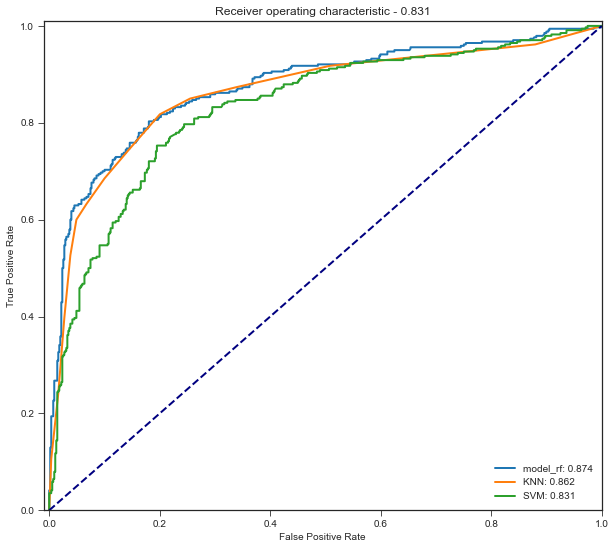

In [347]:
res2plot = []
true = (df[target]==1)
for result in [modelRF, modelknn, modelsvm]:
    # we create a prediction vector creating a pandas series, 
    #and then we sort the index
    pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# We call the drawing function
plotROCs(res2plot)

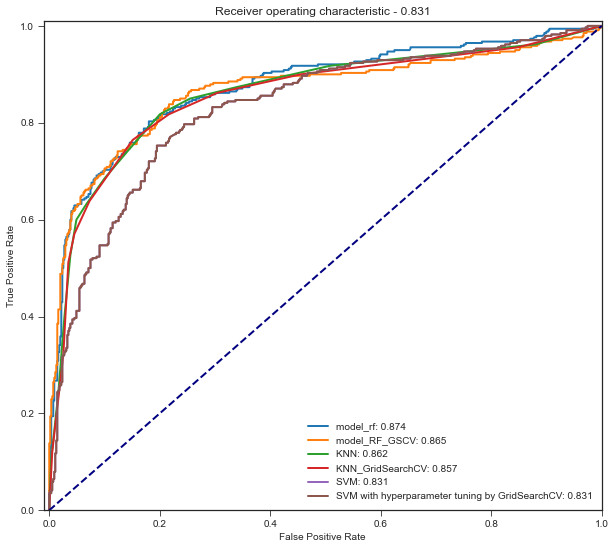

In [354]:
res2plot = []
true = (df[target]==1)
for result in [modelRF,modelRF_GSCV, modelknn,modelknn_GSCV, modelsvm,modelsvm_GSCV]:
    # we create a prediction vector creating a pandas series, 
    #and then we sort the index
    pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# We call the drawing function
plotROCs(res2plot)

### Random Forest after hyperparameter tuning gives the best result.

Survival prediction with the model with the best ROC AUC SCORE

In [356]:
model = RandomForestClassifier(n_estimators=500, max_depth=6, max_features=8, 
                               min_samples_split=4)
model.fit(df.loc[:, df.columns != target], df[target])
predictions = model.predict(df_test)
output = pd.DataFrame({'index': df_test.index, 'Survived': predictions})
output.to_csv('survival_on_Titanic_predicton.csv', index=False)
print("END OF THE PROJECT")

END OF THE PROJECT
